<a href="https://colab.research.google.com/github/harnalashok/Clustering/blob/master/uber_trips_clusters_I.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Last amended: 22nd May, 2022
My folder: D:\data\OneDrive\Documents\uber
           /home/ashok/Documents/4.clustering
           
DataSource:
             https://github.com/fivethirtyeight/uber-tlc-foil-response/tree/master/uber-trip-data   
             https://github.com/caroljmcdonald/spark-ml-kmeans-uber  
                   

Ref: knuggets 
    https://www.kdnuggets.com/2020/07/clustering-rideshare-data-uber.html
    Aurelion Book: https://github.com/ageron/handson-ml2/blob/master/09_unsupervised_learning.ipynb

Ref: Using pyspark
    https://github.com/mutukulasureshkumar/K-Means_Clustering_PySpark

Objectives: 
#           1. Use Uber data to perform clustering
               and advise Uber of possible locations to
               use as hub for taxis
            2. Process data in a manner done for
               out-of-core machine learning.
            3. Use MiniBatchKMeans()
            4. Also check when a slice is view or copy!

"""

# Problem
Uber Technologies Inc. is a peer-to-peer ride sharing platform. Uber's platform connects the drivers who can drive to a customer's location. Uber uses machine learning, for calculating pricing to finding the optimal positioning of cars to maximizing profits. We have used the public Uber trip dataset to discuss building a real-time example for analysis and monitoring of car GPS data.

The Uber trip dataset contains data generated by Uber from New York City. The data is freely available on [FiveThirtyEight](https://data.fivethirtyeight.com/).

### Software install & Call libraries

In [50]:
# 0.3 IF not correct versions, 
#     install desied versions
!pip install yellowbrick==1.4
!pip install folium==0.12.1

In [51]:
# 1.0 Call libraries
%reset -f
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score

# 1.1 Visualization
import matplotlib.pyplot as plt
# conda install -c conda-forge folium

import folium
# conda install -c districtdatalabs yellowbrick
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import silhouette_visualizer

# 1.2
import os,time,gc


In [52]:
# 1.3 Let therebe display from multiple commands
#     from a jupyter cell:

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [53]:
# 1.4 Check
import yellowbrick
yellowbrick.__version__   # 1.4

# 1.4.1
import folium
folium.__version__        # 0.12.1

'1.4'

'0.12.1'

In [54]:
# 1.5 Connect to your google drive
#     Transfer rossmann files from 
#     gdrive to colab VM

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# 2.0 Read data:

pathToFile = "/content/drive/MyDrive/Colab_data_files/uber"
os.chdir(pathToFile)

### Read data

In [56]:
# 2.1 This data has no header:

data = pd.read_csv(
                   "uber_raw_data_apr_sep2014.csv.zip",
                   header = None
                   )

In [57]:
# 2.1.1

data.head()

,0,1,2,3
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [58]:
# 2.1.2 Assign column names:

data.columns = ["dtime","lat","long","base"]
data.head()

,dtime,lat,long,base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [59]:
# 2.1.3 Else, read data, as:

data = pd.read_csv(
                    "uber_raw_data_apr_sep2014.csv.zip",
                    names =["dtime","lat","long","base"]
                   )

# 2.1.4 About data
data.shape    # (45,34,327, 4)
data.head()
data.dtypes

(4534327, 4)

,dtime,lat,long,base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


dtime     object
lat      float64
long     float64
base      object
dtype: object

In [ ]:
# 2.1.5 Else, read data, as:

data = pd.read_csv(
                     "uber_raw_data_apr_sep2014.csv.zip",
                     names =["dtime","lat","long","base"],
                     parse_dates = ['dtime']                     # MAke dtype of dtime as datetime
                   )

# 2.1.6 About data:

data.shape    # (45,34,327, 4)
data.head()
data.dtypes

The dataset has 45 lakh observations and four columns. It has four attributes:

> **Date/Time:** The date and time of the Uber pickup.<br>
**Lat(Latitude)**: The latitude of the Uber pickup<br>
**Lon(Longitude)**: The longitude of the Uber pickup.<br>
**Base**: the TLC base company code affiliated with the Uber pickup. <br>

## Understanding View vs Copy

#### Brief dive & diversion into Shared memory
Always use <i>`np.may_share_memory(a,b)`</i> to check if `a` and `b` are copy of each pther or may share memory. Check [here](https://numpy.org/doc/stable/reference/generated/numpy.may_share_memory.html)

In [100]:
# 3.0 We need only two columns
#     to perform clustering:

clus =  data[["lat","long"]]    # Fancy indexing
clus1 = data.iloc[:, 1:3]       # Pandas slice 

In [101]:
# 3.1 Both are copies not views
#      Takes time:
np.may_share_memory(clus.to_numpy(), data.to_numpy())  # False; A copy
np.may_share_memory(clus1.to_numpy(), data.to_numpy()) # False; A copy not a view

False

False

In [ ]:
# 3.2 First convert DataFrame to numpy array
dt = data.to_numpy()

# 3.2.1 Then slice numpy array:
clus2 = dt[:,1:3]

# 3.2.2 Is it copy or view?
np.may_share_memory(clus2,dt)   # True; it is a view

True

In [ ]:
# 3.2.3 This also works but it modifies original data:
clus2[0,0] = 900
(dt == 900).sum()   # 1

1

In [ ]:
# 3.3 Delete all objects tha we have created:
del clus2
del clus1
del dt
del clus

# 3.4 Collect garbage from memory
gc.collect()


3642

## Begin Clustering

### Take sample

In [61]:
# 4.0 We need only two columns
#     to perform clustering:
#     Take 400000 rows if you have small RAM
#     clus is a copy of data.

clus = data.sample(n=400000)
clus = clus[["lat","long"]]

In [62]:
# 4.1 Else, take whole data
#     We need only two columns
#     to perform clustering:

#clus = data[["lat","long"]]

### Quick clusters
Create two clusters and get various cluster metrics

In [63]:
# 5.0 Quickly create a clustering model:

# 5.1 Instantiate class with parameter values
model = KMeans(
               n_clusters = 2,
               max_iter = 300
               )

# 5.2 Train the obkect on data:

model.fit(clus)    

KMeans(n_clusters=2)

#### Cluster labels

In [64]:
# 5.3 So which data point falls in which cluster:

model.labels_   # Which point falls in which cluster

print("\n\n----")

# 5.3.1 More detail check
model.labels_[:30]

array([0, 1, 0, ..., 0, 0, 0], dtype=int32)



----


array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

#### Centroids

In [65]:
# 5.4 Where are cluster centers?

model.cluster_centers_ # Location of centroids

array([[ 40.74015329, -73.98468782],
       [ 40.72772924, -73.81567244]])

#### SSE: Sum of squared Errors

In [66]:
# 5.5 What is the sum of squares from each pt to respective cluster center?

model.inertia_   # Around 1212

1193.8605370078549

#### How is Silhoutte coefficient calculated


The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). To clarify, b is the distance between a sample and the nearest cluster that the sample is not a part of. 

Silhoutte score when x1 is part of cluster of C1.

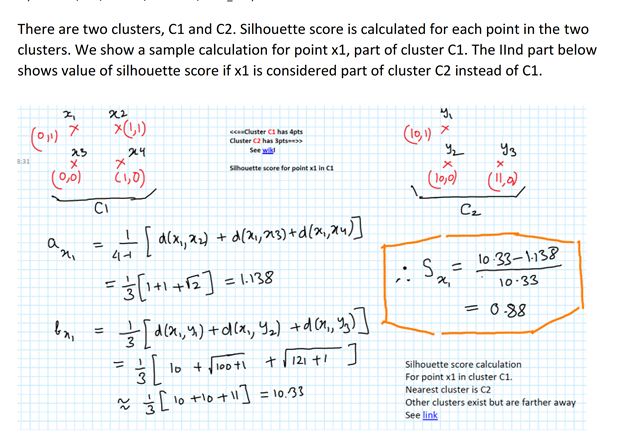

Silhoutte score when x1 is taken to be part of cluster-II

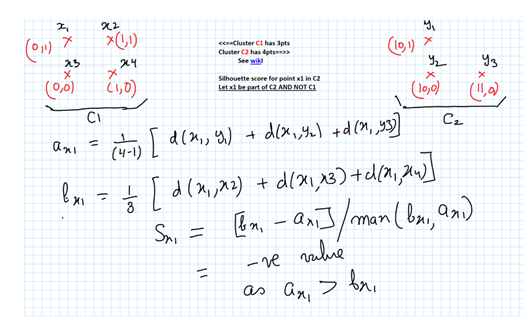

In [67]:
# 5.6 It is computationally very costly
#      to calculate Silhoutte score:


score =silhouette_score(
                       clus,                 # Original data
                       model.labels_,        # Corresponding cluster labels
                       sample_size = 1000    # Note that score is calculated for a sample
                       )


score    # About 0.690

0.7023200484019692

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


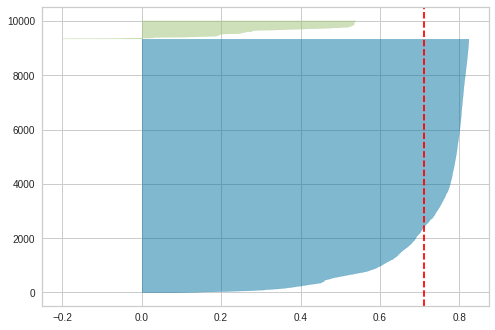

In [68]:
# Steps:
#       Instantiate (with your kmeans model) a silhoutte visualizer object 
#       Fit it on data--Calculate distances and scores
#       Plot it
#
# 6.0 # Instantiate a SilhoutteVisualizer object
#       Ref: https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

visualizer = SilhouetteVisualizer(
                                  model,
                                  colors='yellowbrick'
                                  )

visualizer.fit(clus[:10000])   ;     # Fit the data to the visualizer

visualizer.show()                    # Finalize and render the figure

### How many clusters?

In [72]:
# 7.0 What should be the number of clusters?

inertia = []
s_score = []


# 7.1
start = time.time()
for i in range(2,10):

    # 7.1.2 The model
    model = KMeans(n_clusters = i, max_iter = 300)
    model.fit(clus)     

    # 7.1.3 Store inertia value
    inertia.append(model.inertia_)
    
    # 7.1.4 Calculate silhoutte score
    t=silhouette_score(
                       clus,
                       model.labels_,
                       sample_size = 10000    # Note that score is calculated for a sample
                       )
    
    # 7.1.5
    s_score.append(t)
    print()

end = time.time()
(end-start)/60    # 7minutes

KMeans(n_clusters=2)

KMeans(n_clusters=3)

KMeans(n_clusters=4)

KMeans(n_clusters=5)

KMeans(n_clusters=6)

KMeans(n_clusters=7)

KMeans()

KMeans(n_clusters=9)

0.8836435993512471

#### Scree plot and Silhoutte score

In [79]:
# 7.2 Values of inertia:
for i,j in enumerate(inertia):
  print (i,j)



0 1193.8605552029085
1 929.4700928341322
2 759.1659043855692
3 584.1032448128326
4 474.23627046725875
5 399.0333653202804
6 348.27125811684084
7 308.2461961125499



---


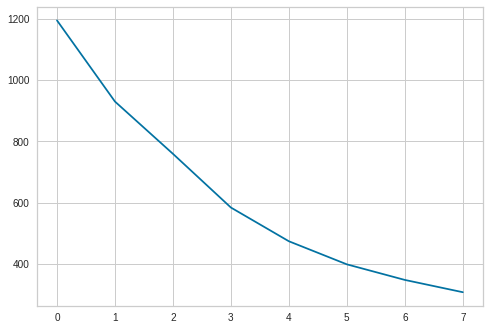

In [80]:
# 7.3 Elbow plot
plt.figure() ;
plt.plot(inertia) ;
plt.show() ;

From the above elbow plot, we can see that 
the sum of the squared distance of the 
observations from their closest cluster 
centroid keeps decreasing with an increase 
in the number of clusters. We can see that 
after K=6 there is a significant reduction. 
We can choose either 6 or 7 clusters, and for 
this application we have chosen 6.


[0.7089540497822212,
 0.3731802469567943,
 0.44928397856011415,
 0.4073743925918667,
 0.4435072442609202,
 0.4514962264433675,
 0.45661811863870844,
 0.41974475424202856]


---



<Figure size 576x396 with 0 Axes>

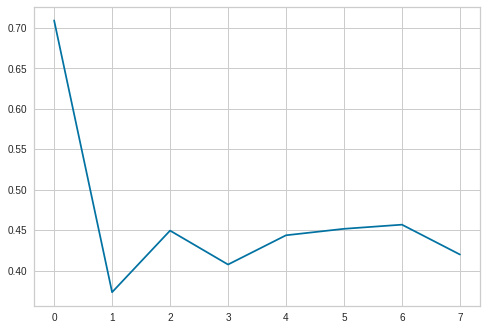

In [83]:
# 7.3 Values of silhoutte score
s_score
print("\n---\n")


# 7.4 Silhoutte score plot
plt.figure()
plt.plot(s_score)
plt.show()

### Final model
We will use `MiniBatchKMeans`. It is much faster! However, its performance is often lower (higher inertia), and it keeps degrading as k increases. See more here.

In [84]:
# 8.0 Perform clustering with 6 clusters
#     MinBatchKMEans converges very fast:

start = time.time()
model = MiniBatchKMeans(
                          n_clusters=6,
                          batch_size=500000,  # Max batch size
                          max_iter=300
                        )
# 8.1
model.fit(clus)
end = time.time()
print()

#(end-start)/60

# 5.0
#model = KMeans(
#                n_clusters = 6,
#                max_iter = 300
#               )

# 5.1

#model.fit(clus)
#end = time.time()
#(end-start)/60

MiniBatchKMeans(batch_size=500000, max_iter=300, n_clusters=6)

In [86]:
# 8.2 About the model
#     We get labels about all
#     rows. Here is  a sample: 

model.labels_[:10]
print()

# 8.2.1
model.inertia_
print()

array([3, 1, 3, 3, 2, 3, 3, 2, 2, 4], dtype=int32)

474.40937040392237

In [87]:
# 8.3 Create a new column
#     

clus_read = np.hstack(
                     [ clus,
                       model.labels_.reshape(model.labels_.shape[0],1)
                     ]
                )

# 8.3.1 Check
clus_read.shape

(400000, 3)

#### Silhoutte score calculation

In [ ]:
# 9.0 Shuffle data
x = np.arange(clus_read.shape[0])
np.random.shuffle(x)
clus_read = clus_read[x]

In [91]:
# 9.1 Mean silhoutte score
silhouette_score(
                 clus_read,
                 model.labels_,
                 sample_size=5000   # For calculation of silhoutte score
                 )

0.9695406442562661

#### Silhoutte plot

In [92]:
# 9.2
# Ref: https://www.scikit-yb.org/en/latest/api/cluster/silhouette.html

visualizer = SilhouetteVisualizer(
                                  model,
                                  colors='yellowbrick'
                                  )

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MiniBatchKMeans was fitted with feature names
  "X does not have valid feature names, but"


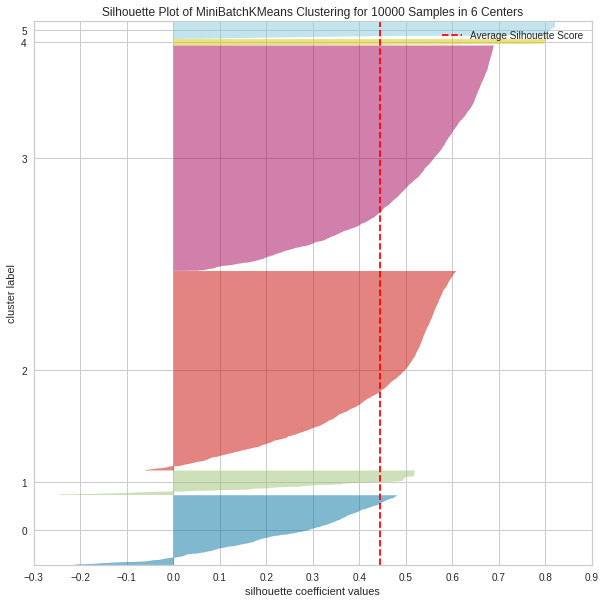

0.0565212885538737

In [93]:
# 9.3
fig = plt.figure(figsize= (10,10))
start = time.time()
_= visualizer.fit(clus[:10000])        # Fit the data to the visualizer
_= visualizer.show()        # Finalize and render the figure
end = time.time()
(end-start)/60


#### Cluster centroids on map

In [95]:
# 10.0
centroids = model.cluster_centers_

# 5.1 Transform  centroids to a DataFrame
clocation = pd.DataFrame(
                         centroids,
                         columns = ["Latitude", "Longitude"]
                         )

# 10.1
clocation

,Latitude,Longitude
0,40.687404,-73.964030
1,40.794932,-73.870445
2,40.766331,-73.972426
3,40.730842,-73.998244
4,40.698279,-74.201259
5,40.663722,-73.764265


In [96]:
# 10.2 What are mean centroid values
lat_mean = clocation['Latitude'].mean()
long_mean = clocation['Longitude'].mean()

In [97]:
# 10.3 Converting centroid into lists
centroid = clocation.values.tolist()

# 10.4 Plotting the centroids on google map using Folium library.
map = folium.Map(
                  # Center the map here
                  location=[lat_mean,long_mean],
                  zoom_start = 10
                )

# 10.5 
for point in range(0, len(centroid)):
    abc=folium.Marker(
                      centroid[point],
                      popup = centroid[point]
                      ).add_to(map)

    

In [ ]:
# 11.0 Draw google map
map

#### Conclusions

We can see that all the six centroids have been plotted on the map. How are these centroids helpful for Uber?

>    Uber can use these centroids as their hubs. Whenever Uber receives a new ride request, they can check the closeness with each of these centroids. Whichever particular centroid is closer, Uber can direct the vehicle from that particular location to the customer location.<br>

>    Uber has many drivers and provides services to many locations. If Uber knows the hub (particular centroid), and if they are getting a lot of ride request then strategically they can place their drivers in better locations wherein their probability of getting a ride request is greater. This will help Uber to serve the customer faster as vehicles are placed closer to the location and also help to grow their business.<br>

>   Uber can make use of these centroids for the optimal placing of their vehicles. They can find which centroid at which part of the day have more ride requests. For example, if Uber gets more request from centroid 0 (cluster 1) at 11 AM, but far fewer requests from centroid 3 (cluster 4), then they can redirect the vehicles to cluster 1 from cluster 4 (if there is an increased vehicle presence in cluster 4).<br>

>   Uber can use these centroids for optimal pricing by analyzing which cluster deals with maximum requests, peak times etc. Suppose they don’t have many vehicles available to be sent to a particular location (more demand), then they can do optimal pricing as demand is high and supply is less. <br>

In [ ]:
# https://seaborn.pydata.org/generated/seaborn.catplot.html
_= sns.catplot(
                   data = clus,
                   x = 'Clusters',
                   kind = 'count',
                   size = 7,
                   order = [2,0,4,5,1,3] # Order of display
                  )

In [ ]:
# 3.0 Predicting on a new location
new_location = [(40.6556,-73.5631)]
kmeans.predict(new_location)

In [ ]:
####### I am done ################